# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: December 28, 2020

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
matplotlib.rcParams.update({'font.size': 22})
eps = 1e-12

In [24]:
def CD_calc(Re=None, U=None, D=None, rho=None, mu=None):
    """
    Calculates the the Drag coefficient (CD) and the corresponding Drag force (FD), using the empirical equation found in the
    reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf
    
    Use SI units
    
    """
    if Re is None:
        Re = rho*U*D/mu
    
    # Check to make sure Re value provided is consistent:
    if Re is not None:
        if U is not None:
            assert Re==rho*U*D/mu, "Provided Re is inconsistent with U, D, rho, and mu provided!"
            
    CD = (24/Re) \
    + ((2.6*(Re/5.)) / (1+(Re/5.)**1.52)) \
    + ((0.411*(Re/2.63e5)**-7.94) / (1 + (Re/2.63e5)**-8.)) \
    + ((0.25*(Re/1e6)) / (1 + (Re/1e6)))

    # Calculate FD if U and D and rho are given:
    if U is not None:
        FD = CD * (rho*np.pi/8) * (U**2) * (D**2)
    else:
        FD = None
        
    return CD, FD

def run_experiment(velocities, diameter, density, viscosity):
    """
    Runs the experiment by iterating over the velocity vector us and returning the drag coefficient CD and Drag force FD
    
    """
    FDs = np.zeros(len(velocities))
    CDs = np.zeros(len(velocities))
    for ind, u in enumerate(velocities):
        CDs[ind], FDs[ind] = CD_calc(Re=None, U=u, D=diameter, rho=density, mu=viscosity)
        
    return CDs, FDs

In [25]:
# # Test CD Forward Solver:
# Re_vec = np.geomspace(0.001, 1e7, 200)
# CD_vec = []
# for r in Re_vec:
#     CD_vec.append(CD_calc(Re=r))

In [26]:
def plot_CD(Re, CD, marker):
    plt.figure(figsize=(6,6))
    plt.loglog(Re, CD, marker)
    plt.ylim(1e-2, 1e4)
    plt.xlim(1e-2, 1e7)
    plt.xlabel('$Re$')
    plt.ylabel('$C_D$')
    return True

def plot_FD(Re, FD, marker):
    fig = plt.figure(figsize=(6,6))    
    plt.loglog(Re, FD, marker)
    plt.ylim(eps, 1e4)
    plt.xlim(1e-2, 1e7)
    plt.xlabel('$Re$')
    plt.ylabel('$F_D$')
    return True

def make_plots(Re, CD, FD, experiment_id, colors=['blue', 'blue'], fig=None, ax1=None, ax2=None, ylabel='$C_D$'):
#     fig = plt.figure(figsize=(6,6))
    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.loglog(Re, CD, color=colors[0], marker='o')
    ax1.set_xlabel('$Re$')
    ax1.set_ylabel(ylabel)


    ax2.loglog(Re, FD, color=colors[1], marker='o')
    ax2.set_xlabel('$Re$')
    ax2.set_ylabel('$F_D$')

    plt.subplots_adjust(right=3)
    fig.suptitle(experiment_id)
    
    return fig, ax1, ax2

In [27]:
# # Plot results from the forward solver:
# plt.figure(figsize=(6,6))
# plt.loglog(Re_vec, CD_vec, 'b-o')
# plt.ylim(1e-2, 1e4)
# plt.xlim(1e-2, 1e7)
# plt.xlabel('$Re$')
# plt.ylabel('$C_D$')

There are other ways to non-dimensionalize the $F_D$:  
$\Pi_1$ := $C_D$ = $\frac{F_D}{\rho.U^2.D^2}$ (Works!) 

$\Pi_2$ = $\frac{F_D}{\mu.U.D}$  (Works!)

$\Pi_3$ = $\frac{\rho.F_D}{\mu^2}$  (Works!)

Assuming we can generate $F_D$ (i.e., experimentally), we want to explore the following:
* Plot the other $\Pi$ groups as a function for $Re$ to see how they look  
* If we were to randomly sample the main physical parameters (i.e., $\rho$, $U$, $\mu$, $D$), how efficiently and how well can we estimate $F_D$? The ground-truth is taken to be the experimental $C_D$ values fitted above.
* If instead, of the main physical parameters we use $Re$, $U$, $D$, and $\rho$ can we estimate $F_D$ more efficiently or better?
* How do I best visualize $F_D$ vs. $Re$? We expect the curve not to be as nice?
* To start, let's keep $\rho$ and $\mu$ constant? Let's try water....

For all estimates, we will try first to use a deep fully connected network with some non-linearity.

Insight?: The non-dimensionalization helps with more efficient sampleing of the independent variable space? Uniformly sampling $Re$ more efficiently covers the space. 

## Experiments:
Generating some 'experimental' data and comparing different $\Pi$ groups

### Material parameters:

In [28]:
# Let's take water as an example: rho = 1000Kg/m^3, mu = 0.001 Ns/M^2
# c_sound (Cs) in water ~ 1481 m/s, Cs(Acetone) = ~1100 m/s - We need to make sure the velocity is < 0.3*Cs
N = 200 # Number of samples
Cs = 1481 # m/s
u_max = 0.3 * Cs # Picked 0.2 to make sure the condition is not violated for acetone

mu_water = 0.001 # [SI]
rho_water = 1000 # [SI]

mu_acetone = 0.000316 # Acetone [SI]
rho_acetone = 784.5 # Acetone [SI]

# Sphere diameters:
D_I = 0.05 # Diameter of sphere
D_II = 0.1
D_III = 0.5

### Setting up the 'Experiments':

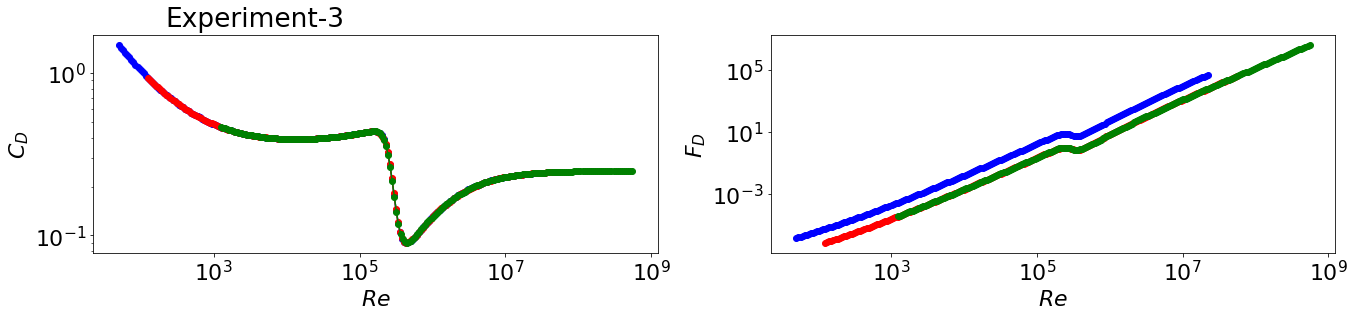

In [29]:
# Let's keep the velocities the same for now:
us = np.geomspace(0.001, u_max, N)

# Experiment #1:
mu_1 = mu_water
rho_1 = rho_water
D_1 = D_I
REs_1 = [rho_1*uu*D_1/mu_1 for uu in us]
CDs_1, FDs_1 = run_experiment(velocities=us, diameter=D_1, density=rho_1, viscosity=mu_1)
fig, ax1, ax2 = make_plots(Re=REs_1, CD=CDs_1, FD=FDs_1, experiment_id='Experiment-1', colors=['blue', 'blue'])

# Experiment #2:
mu_2 = mu_acetone
rho_2 = rho_acetone
D_2 = D_I
REs_2 = [rho_2*uu*D_2/mu_2 for uu in us]
CDs_2, FDs_2 = run_experiment(velocities=us, diameter=D_2, density=rho_2, viscosity=mu_2)
fig, ax1, ax2 = make_plots(Re=REs_2, CD=CDs_2, FD=FDs_2, experiment_id='Experiment-1 and 2', colors=['red', 'red'], fig=fig, ax1=ax1, ax2=ax2)

# Experiment #3:
mu_3 = mu_acetone
rho_3 = rho_acetone
D_3 = D_III
REs_3 = [rho_3*uu*D_3/mu_3 for uu in us]
CDs_3, FDs_3 = run_experiment(velocities=us, diameter=D_3, density=rho_3, viscosity=mu_3)
fig, ax1, ax2 = make_plots(Re=REs_3, CD=CDs_3, FD=FDs_3, experiment_id='Experiment-3', colors=['green', 'green'], fig=fig, ax1=ax1, ax2=ax2)

### Comparing to other $\Pi$ groups:
It appears $\Pi_4$ does not work but the rest do! Why??

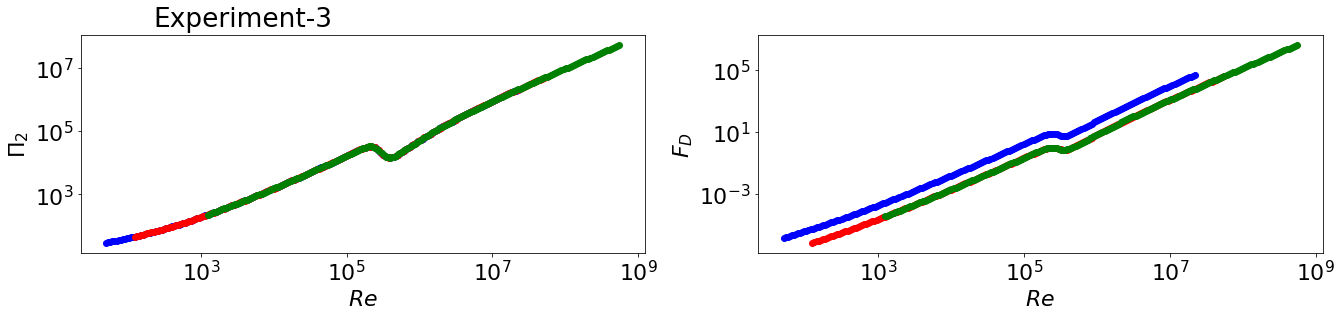

In [30]:
# Comparing the following Pi group:

# Experiment #1:
mu_1 = mu_water
rho_1 = rho_water
D_1 = D_I
REs_1 = [rho_1*uu*D_1/mu_1 for uu in us]
CDs_1, FDs_1 = run_experiment(velocities=us, diameter=D_1, density=rho_1, viscosity=mu_1)
# fig, ax1, ax2 = make_plots(Re=REs_1, CD=CDs_1, FD=FDs_1, experiment_id='Experiment-1', colors=['blue', 'blue'])

pi2_1 = [FDs/(mu_1*D_1*uu) for (FDs, uu) in zip(FDs_1, us)]
pi3_1 = [FDs*rho_1/mu_1**2 for FDs in FDs_1]

fig, ax1, ax2 = make_plots(Re=REs_1, CD=pi2_1, FD=FDs_1, experiment_id='Experiment-1', 
                           colors=['blue', 'blue'], ylabel='$\Pi_2$')

# Experiment #2:
mu_2 = mu_acetone
rho_2 = rho_acetone
D_2 = D_I
REs_2 = [rho_2*uu*D_2/mu_2 for uu in us]
CDs_2, FDs_2 = run_experiment(velocities=us, diameter=D_2, density=rho_2, viscosity=mu_2)

pi2_2 = [FDs/(mu_2*D_2*uu) for (FDs, uu) in zip(FDs_2, us)]
pi3_2 = [FDs*rho_2/mu_2**2 for FDs in FDs_2]

fig, ax1, ax2 = make_plots(Re=REs_2, CD=pi2_2, FD=FDs_2, experiment_id='Experiment-1 and 2', 
                           colors=['red', 'red'], fig=fig, ax1=ax1, ax2=ax2, ylabel='$\Pi_2$')


# Experiment #3:
mu_3 = mu_acetone
rho_3 = rho_acetone
D_3 = D_III
REs_3 = [rho_3*uu*D_3/mu_3 for uu in us]
CDs_3, FDs_3 = run_experiment(velocities=us, diameter=D_3, density=rho_3, viscosity=mu_3)

pi2_3 = [FDs/(mu_3*D_3*uu) for (FDs, uu) in zip(FDs_3, us)]
pi3_3 = [FDs*rho_3/mu_3**2 for FDs in FDs_3]

fig, ax1, ax2 = make_plots(Re=REs_3, CD=pi2_3, FD=FDs_3, experiment_id='Experiment-3', 
                           colors=['green', 'green'], fig=fig, ax1=ax1, ax2=ax2, ylabel='$\Pi_2$')

Some more ideas discussed with Hamed (December 27th, 2020):
* Can we somehow use different units (e.g., SI vs imperial) to allow the network to learn the invariance to change of units?
* Explore online data collection...depending on the results of a given experiment, the network selects what data point is needed
* Can we use the knowledge of the number of possible dimensionless groups to create an appropriate architecture? For example, one simple way in this case is to use two nodes in the penultimate (or else) layer since we expect a simpler relationship between the two $\Pi$ groups. 

## Neural Net Regression
Method #1:  
$F_D$ = $f(\rho, \mu, U, D)$

Method #2:  
$F_D$ = $f(Re, \rho, U, D)$

Method #3:  
$C_D$ = $f(Re, \rho, U, D)$

For all three methods, we use a deep neural network to approximate the function $f$.

### Dataset creation:

In [48]:
# Uncomment the following if you want to re-generate the dataset. It takes a couple of minutes.

# # Picking some ranges for the parameters:
# N = 50 # Number of points
# mu_vec = np.linspace(0.0001, 0.01, N)
# rho_vec = np.linspace(500, 2000, N)
# U_vec = np.linspace(0.001, 200, 2*N)
# D_vec = np.linspace(0.01, 0.1, N)

# FDs = np.zeros((N, N, 2*N, N))
# CDs = np.zeros((N, N, 2*N, N))
# counter = 0
# X, Y = [], []
# for ii, m in enumerate(mu_vec):
#     for jj, r in enumerate(rho_vec):
#         for kk, u in enumerate(U_vec):
#             for ll, d in enumerate(D_vec):
#                 CDs[ii, jj, kk, ll], FDs[ii, jj, kk, ll] = CD_calc(Re=None, U=u, D=d, rho=r, mu=m)
#                 X.append([m, r, u, d])
#                 Y.append(FDs[ii, jj, kk, ll])
                
# X = np.array(X)
# Y = np.array(Y)

In [49]:
X.shape

(12500000, 4)

In [50]:
# Saving the generated data in the previous cell:
# with open('dataset1.npy', 'wb') as f:
#     np.save(f, mu_vec)
#     np.save(f, rho_vec)
#     np.save(f, U_vec)
#     np.save(f, D_vec)
#     np.save(f, CDs)
#     np.save(f, FDs)
#     np.save(f, X)
#     np.save(f, Y)
    
# Loading the saved generated data:
with open('dataset1.npy', 'rb') as f:
    mu_vec = np.load(f)
    rho_vec = np.load(f)
    U_vec = np.load(f)
    D_vec = np.load(f)
    CDs = np.load(f)
    FDs = np.load(f)
    X = np.load(f)
    Y = np.load(f)

In [22]:
#TODO:
- Figure out how to organize the dataset most effectively
- Do the multivariate regression using multiple hidden units

(50, 50, 100, 50)